# Deciphering Aesthetics: Investigating the Role of Image Resolution 
# in Housing Price Prediction Models

- Barcelona School of Economics

- Authors: Luis Quiñones, Tobias Pfeiffer
- Course: Deep Learning Applications 
- Professors: Clément Gorin, Edoardo Nemni


In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.python import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model, model_from_yaml
from keras.layers import concatenate
from sklearn.metrics import r2_score, explained_variance_score
import requests
import os


### Helper Functions: 

In [2]:
def grad_cam(model, img,
             layer_name="block5_conv3", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id is None:
            category_id = np.argmax(predictions[0])
        if label_name is not None:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)



In [3]:
def preprocess_image(img_path, target_size=(512, 512)):
    """Preprocess the image by reshape and normalization.

    Args:
        img_path: A string.
        target_size: A tuple, reshape to this size.
    Return:
        An image array.
    """
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img /= 255

    return img


def show_imgwithheat(img_path, heatmap, alpha=0.3, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)

    if return_array:
        return superimposed_img
    else:
        try:
            display(imgwithheat)
        except NameError:
            imgwithheat.show()

Load the data:

In [4]:
#textfile_path = "C:\\Users\\HP\\Desktop\\Barcelona\\Term3\\DeepLearningApplication\\term_paper\\HousesDataset\\HousesInfo.txt"
textfile_path = "HousesDataset/HousesInfo.txt"

col = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

text_data = pd.read_csv(textfile_path, sep = ' ', names = col)

text_data.head(10)


bedrooms  bathrooms  area  zipcode    price
0         4        4.0  4053    85255   869500
1         4        3.0  3343    36372   865200
2         3        4.0  3923    85266   889000
3         5        5.0  4022    85262   910000
4         3        4.0  4116    85266   971226
5         4        5.0  4581    85266  1249000
6         3        4.0  2544    85262   799000
7         4        5.0  5524    85266  1698000
8         3        4.0  4229    85255  1749000
9         4        5.0  3550    85262  1500000

Since house prices have a high magnitude we use the highest price to scale.

In [5]:
p_max = text_data['price'].max()

In [6]:
y = text_data['price']
text_data = text_data.drop(columns='price', axis=1)

X = text_data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=420)

The following fucntion groups the photos associated with an id into one. *image_split_lr()* produced a low resolution image while *image_split_hr()* produces a high resolution image. We hope differences in the MSE/R² can help to quantify the effect of visual features.

In [7]:
def image_split(df, new_size):
    images = []

    for i in df.index.values:
        housePaths = sorted(list(glob.glob("HousesDataset/{}_*".format(i+1))))

        inputImages = []
        outputImage = np.zeros((new_size, new_size, 3), dtype = "uint8")
                
        for housePath in housePaths : 
            image = cv2.imread(housePath)
            image = cv2.resize(image, (new_size//2, new_size//2), interpolation = cv2.INTER_CUBIC)
            inputImages.append(image)

            if len(inputImages) >= 4: 
                outputImage[0:new_size//2, 0:new_size//2] = inputImages[0]
                outputImage[0:new_size//2, new_size//2:new_size] = inputImages[1]
                outputImage[new_size//2:new_size, new_size//2:new_size] = inputImages[2]
                outputImage[new_size//2:new_size, 0:new_size//2] = inputImages[3]
            
                images.append(outputImage)

    return images


In [8]:
X_train_img_lr = image_split(y_train, 64)
X_test_img_lr = image_split(y_test, 64)

X_train_img_hr = image_split(y_train, 512)
X_test_img_hr = image_split(y_test, 512)

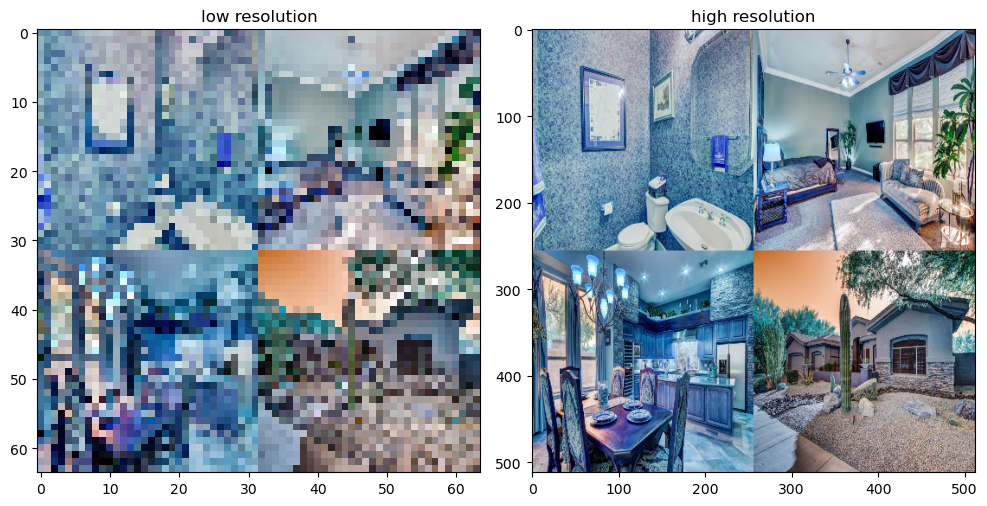

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train_img_lr[1])
axs[0].set_title('low resolution')

axs[1].imshow(X_train_img_hr[1])
axs[1].set_title('high resolution')

plt.tight_layout()

plt.show()

In [10]:
# standarise images
X_train_img_lr = np.multiply(X_train_img_lr, (1/255))
X_test_img_lr = np.multiply(X_test_img_lr, (1/255))

X_train_img_hr = np.multiply(X_train_img_hr, (1/255))
X_test_img_hr = np.multiply(X_test_img_hr, (1/255))

# y is the price of the house corresponding to house i
y_train = np.stack(y_train)
y_train = y_train / p_max
y_test = np.stack(y_test)
y_test = y_test / p_max

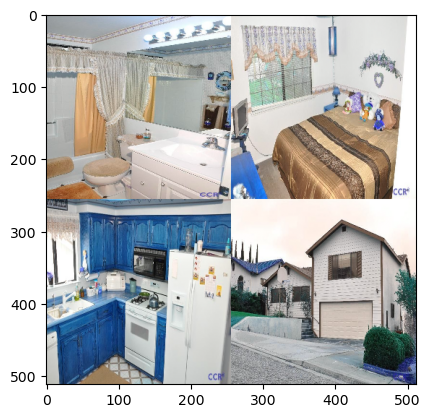

In [11]:
# visualisation pt. II
plt.imshow(X_test_img_hr[3])
plt.show()

In [12]:
# check dimensions:
print(f'{X_train_img_lr.shape} is the dimension of the training images (lr)')
print(f'{X_train_img_hr.shape} is the dimension of the training images (hr)')
print(f'{X_train.shape} is the dimension of the training data')
print(f'{y_train.shape} is the dimension of y train')

print(f'{X_test_img_lr.shape} is the dimension of the testing images (lr)')
print(f'{X_test_img_hr.shape} is the dimension of the testing images (hr)')
print(f'{X_test.shape} is the dimension of the testing data')
print(f'{y_test.shape} is the dimension of y test')

(481, 64, 64, 3) is the dimension of the training images (lr)
(481, 512, 512, 3) is the dimension of the training images (hr)
(481, 4) is the dimension of the training data
(481,) is the dimension of y train
(54, 64, 64, 3) is the dimension of the testing images (lr)
(54, 512, 512, 3) is the dimension of the testing images (hr)
(54, 4) is the dimension of the testing data
(54,) is the dimension of y test


In [13]:
print(X_train.isna().sum())
print(X_test.isna().sum())

bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64
bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64


In [14]:
def standardise_df(df, df_test):

    scaler = MinMaxScaler()

    df_standardized = scaler.fit_transform(df)
    df_standardized_test = scaler.transform(df_test)

    return df_standardized, df_standardized_test

In [15]:
X_train, X_test = standardise_df(X_train, X_test)

## Models
1. Build Baseline Model (Neural Network for tabular data)
2. Build Low Resolution Model with Text Features
3. Build High Resolution Model with Text Features
4. Build Model with High 5esolution images Only
5. Build Model with Low Resolution images Only

In [16]:
baseline = Sequential()
baseline.add(Dropout(0.2, input_shape=(4,)))
baseline.add(Dense(16, activation='relu'))
baseline.add(Dense(4, activation='relu'))
baseline.add(Dense(1, activation='linear'))
baseline.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-10 01:05:45.651327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-10 01:05:45.651420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history_baseline = baseline.fit(X_train, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30


2023-06-10 01:05:45.798520: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-10 01:05:45.928992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 17ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 3/30
 1/14 [=>............................] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

2023-06-10 01:05:46.255829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 4/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 6/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 7/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 8/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 9/30
14/14 [==============================] -

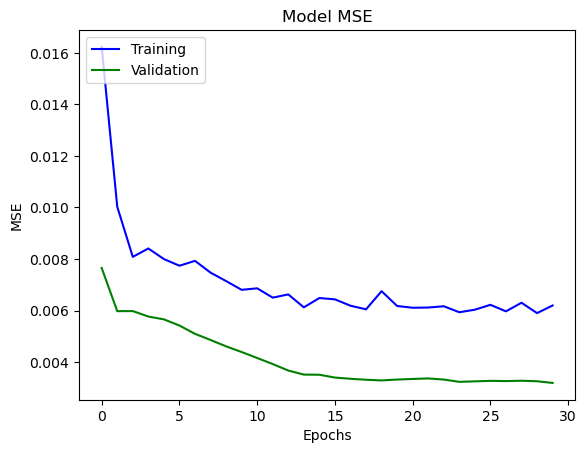

In [18]:
plt.plot(history_baseline.history['loss'], color='b')
plt.plot(history_baseline.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [19]:
predictions_baseline = baseline.predict(X_test)

2/2 [==============================] - 0s 9ms/step


2023-06-10 01:05:49.053482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
error = predictions_baseline.flatten() - y_test
squared_error = error ** 2
MSE_baseline = np.mean(squared_error)
print(MSE_baseline)

0.003385954297943189


In [21]:
def tabular_nn():
    nn = Sequential()
    nn.add(Dropout(0.2, input_shape=(4,)))
    nn.add(Dense(16, activation='relu'))
    nn.add(Dense(4, activation='relu'))
    nn.add(Dense(1, activation='linear'))
    return nn

In [22]:
def cnn(size):
    model = Sequential()

    initializer = 'he_uniform'  # Set the initializer

    model.add(Input(shape=size, name='input_layer'))

    model.add(Conv2D(filters=16, kernel_size=(7, 7), strides=(2,2), padding='same', activation=None, use_bias=False, kernel_initializer=initializer, name='conv_layer1'))
    model.add(BatchNormalization(name='batchnorm_layer1'))
    model.add(Activation('relu', name='activation_layer1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer1'))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=None, use_bias=False, kernel_initializer=initializer, name='conv_layer2'))
    model.add(BatchNormalization(name='batchnorm_layer2'))
    model.add(Activation('relu', name='activation_layer2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer2'))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, use_bias=False, kernel_initializer=initializer, name='conv_layer3'))
    model.add(BatchNormalization(name='batchnorm_layer3'))
    model.add(Activation('relu', name='activation_layer3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer3'))

    model.add(Flatten(name='flatten_layer'))

    model.add(Dense(units=128, activation=None, kernel_initializer=initializer, name='dense_layer1'))
    model.add(BatchNormalization(name='batchnorm_layer4'))
    model.add(Activation('relu', name='activation_layer4'))

    model.add(Dense(units=64,  activation=None, kernel_initializer=initializer, name='dense_layer2'))
    model.add(BatchNormalization(name='batchnorm_layer5'))
    model.add(Activation('softmax', name='activation_layer5'))

    model.add(Dense(units=4,  activation='softmax', kernel_initializer=initializer, name='output_layer'))

    return model


This Convolutional Neural Network (CNN) ooperates by applying sequential layers that progressively refine the learning from the property images. Starting with the initial convolutional layer that has 16 filters and a large kernel size of 7x7, the network is designed to capture broad strokes or patterns in the image. This is followed by max-pooling for dimensionality reduction, which retains the most influential features identified by the convolutional layer.

As the network progresses, the kernel size decreases while the number of filters increases, allowing the model to discern more detailed and subtle features in the images. Each convolutional layer is accompanied by a batch normalization layer for faster and more stable convergence, and a 'relu' activation function for introducing non-linearity, enabling the model to learn complex patterns.

Finally, after the last convolutional and max-pooling layer, the model flattens the input and feeds it into dense layers. These layers can learn higher-level features and combine the learned spatial hierarchies from the convolutional layers to make final predictions. The dense layers also use the 'relu' activation function for non-linearity, with a 'softmax' function in the final output layer to provide a probability distribution over the four output units.

In [23]:
tabular_model = tabular_nn()
cnn_model_lr = cnn((64, 64, 3))
cnn_model_hr = cnn((512, 512, 3))

def merge_models(tabular_model, cnn_model):
    merged = concatenate([tabular_model.output, cnn_model.output])
    final_dense = Dense(4, activation='relu')(merged)
    output = Dense(1, activation='linear')(final_dense)

    return Model(inputs=[tabular_model.input, cnn_model.input], outputs=output)

2. low resolution:

In [24]:
model_lr = merge_models(tabular_model, cnn_model_lr)
model_lr.compile(optimizer='adam', loss='mse', run_eagerly=True)


In [25]:
history_lr = model_lr.fit([X_train, X_train_img_lr], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 2s 105ms/step - loss: 0.1631 - val_loss: 0.0460
Epoch 2/30
14/14 [==============================] - 1s 90ms/step - loss: 0.0485 - val_loss: 0.0152
Epoch 3/30
14/14 [==============================] - 1s 89ms/step - loss: 0.0220 - val_loss: 0.0110
Epoch 4/30
14/14 [==============================] - 1s 95ms/step - loss: 0.0162 - val_loss: 0.0088
Epoch 5/30
14/14 [==============================] - 1s 96ms/step - loss: 0.0136 - val_loss: 0.0076
Epoch 6/30
14/14 [==============================] - 1s 94ms/step - loss: 0.0121 - val_loss: 0.0069
Epoch 7/30
14/14 [==============================] - 1s 96ms/step - loss: 0.0113 - val_loss: 0.0066
Epoch 8/30
14/14 [==============================] - 1s 93ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 9/30
14/14 [==============================] - 1s 96ms/step - loss: 0.0100 - val_loss: 0.0060
Epoch 10/30
14/14 [==============================] - 1s 99ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 11

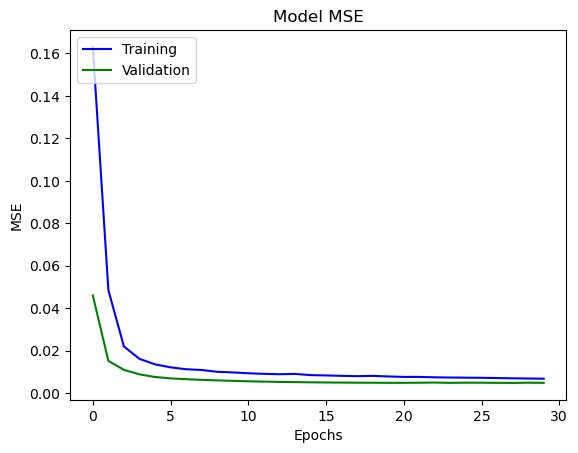

In [26]:
plt.plot(history_lr.history['loss'], color='b')
plt.plot(history_lr.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [27]:
predictions_lr = model_lr.predict([X_test, X_test_img_lr])

2/2 [==============================] - 0s 9ms/step


In [28]:
# MSE
error = predictions_lr.flatten() - y_test
squared_error = error ** 2
MSE_lr = np.mean(squared_error)
print(MSE_lr)

0.0033405944920912476


3. high resolution:

In [29]:
model_hr = merge_models(tabular_model, cnn_model_hr)
model_hr.compile(optimizer='adam', loss='mse', run_eagerly=True)

In [30]:
history_hr = model_hr.fit([X_train, X_train_img_hr], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 7s 456ms/step - loss: 0.0274 - val_loss: 0.0133
Epoch 2/30
14/14 [==============================] - 7s 474ms/step - loss: 0.0173 - val_loss: 0.0094
Epoch 3/30
14/14 [==============================] - 6s 396ms/step - loss: 0.0127 - val_loss: 0.0070
Epoch 4/30
14/14 [==============================] - 5s 361ms/step - loss: 0.0085 - val_loss: 0.0054
Epoch 5/30
14/14 [==============================] - 5s 369ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 6/30
14/14 [==============================] - 6s 412ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 7/30
14/14 [==============================] - 6s 413ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 8/30
14/14 [==============================] - 5s 396ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 9/30
14/14 [==============================] - 5s 389ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 10/30
14/14 [==============================] - 5s 393ms/step - loss: 0.0050 - val_loss: 0.0043

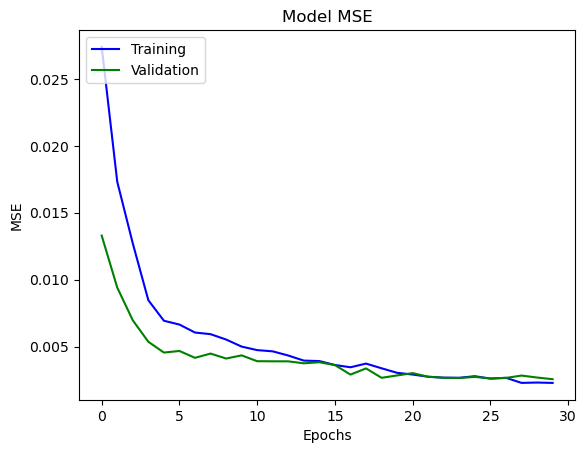

In [31]:
plt.plot(history_hr.history['loss'], color='b')
plt.plot(history_hr.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [32]:
predictions_hr = model_hr.predict([X_test, X_test_img_hr])

2/2 [==============================] - 0s 56ms/step


In [33]:
error = predictions_hr.flatten() - y_test
squared_error = error ** 2
MSE_hr = np.mean(squared_error)
print(MSE_hr)

0.0027697522323296


### Model Comparison of Text features + High and Low resolution images, and Baeline(text only features)

In [34]:
index = ['Baseline', 'Low Resolution', 'High Resolution']
data = [MSE_baseline, MSE_lr, MSE_hr]

results = pd.DataFrame(data, index=index, columns=['MSE'])

In [35]:
results

MSE
Baseline         0.003386
Low Resolution   0.003341
High Resolution  0.002770

High resolution images + text data, performs better from an MSE standpoint then text only, and text + low resolution.

In [46]:
# R-squared scores
r2_baseline = r2_score(y_test, predictions_baseline)
r2_lr = r2_score(y_test, predictions_lr)
r2_hr = r2_score(y_test, predictions_hr)

# Explained Variance scores
evs_baseline = explained_variance_score(y_test, predictions_baseline)
evs_lr = explained_variance_score(y_test, predictions_lr)
evs_hr = explained_variance_score(y_test, predictions_hr)

print("R-squared scores")
print("Baseline: ", r2_baseline)
print("Low Resolution: ", r2_lr)
print("High Resolution: ", r2_hr)

print("\nExplained Variance scores")
print("Baseline: ", evs_baseline)
print("Low Resolution: ", evs_lr)
print("High Resolution: ", evs_hr)


R-squared scores
Baseline:  0.0969288068795533
Low Resolution:  0.10902676520560273
High Resolution:  0.2612766644200346

Explained Variance scores
Baseline:  0.102731684666313
Low Resolution:  0.11764355426160289
High Resolution:  0.26406248054213666


 It appears that leveraging high-resolution visual and textual data can lead to more precise predictions. However, the results reveal that the explained variance by the models (baseline, low-resolution, and high-resolution) is less than anticipated, with values ranging from 9.69% to 26.41%. This indicates that a significant portion of the data's variation is not captured. Interestingly, the incorporation of high resolution images into our model seemed to enhance its performance. This is evident from the improved explained variance (26.41%) and the R-squared score (26.13%), which are the highest among the three models. This suggests that integrating high-resolution images into the model can bolster its predictive accuracy, reducing the prediction error. 

Now we will fit just the high resolution images, without any text data. 

In [37]:
cnn_model = cnn((512, 512, 3))
cnn_model.compile(optimizer='adam', loss='mse')
history_cnn = cnn_model.fit(X_train_img_hr, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))


Epoch 1/30


2023-06-10 01:09:31.219128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.0295

2023-06-10 01:09:36.682098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 6s 360ms/step - loss: 0.0295 - val_loss: 0.0325
Epoch 2/30
14/14 [==============================] - 4s 298ms/step - loss: 0.0295 - val_loss: 0.0313
Epoch 3/30
14/14 [==============================] - 5s 352ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 4/30
14/14 [==============================] - 4s 302ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 5/30
14/14 [==============================] - 4s 310ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 6/30
14/14 [==============================] - 4s 310ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 7/30
14/14 [==============================] - 5s 323ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 8/30
14/14 [==============================] - 4s 319ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 9/30
14/14 [==============================] - 4s 315ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 10/30
14/14 [==============================] - 4s 313ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 11/3

We fit visual only models.

In [38]:
cnn_model2 = cnn((64, 64, 3))
cnn_model2.compile(optimizer='adam', loss='mse')
history_cnn2 = cnn_model2.fit(X_train_img_lr, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30


2023-06-10 01:11:43.986549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 62ms/step - loss: 0.0295 - val_loss: 0.0313
Epoch 2/30


2023-06-10 01:11:45.318354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 31ms/step - loss: 0.0295 - val_loss: 0.0313
Epoch 3/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 4/30
14/14 [==============================] - 0s 29ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 5/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 6/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 7/30
14/14 [==============================] - 0s 30ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 8/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 9/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 10/30
14/14 [==============================] - 0s 29ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 11/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 12/30
14/14 [

In [39]:
predictions = cnn_model.predict(X_test_img_hr)

2/2 [==============================] - 0s 96ms/step


2023-06-10 01:11:56.153861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Grad-CAM Interpretation

Here we want to see what the model prioritizes.

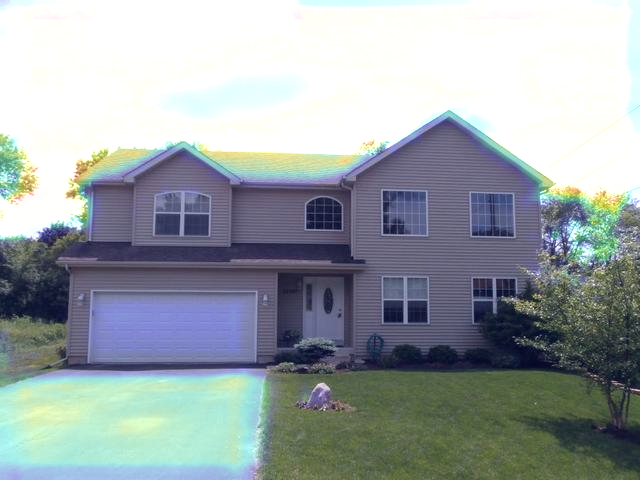

In [40]:
img_path = 'HousesDataset/77_frontal.jpg' 
img = preprocess_image(img_path)  
heatmap = grad_cam(cnn_model, img, 'conv_layer3')

show_imgwithheat(img_path, heatmap)

In [41]:
y_test_original = y_test * p_max
predictions_original = predictions_hr * p_max
average_predictions_hr = predictions_original.mean(axis=1)
predictions_original_lr= predictions_lr * p_max
average_predictions_lr= predictions_original_lr.mean(axis=1)


In [42]:
def plot_images_and_heatmaps(model, img_paths, actual_price, predicted_price, scale: tuple = (512,512)):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid of subplots
    fig.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase space between subplots
    
    for i, img_path in enumerate(img_paths):
        img = preprocess_image(img_path,(scale))
        heatmap = grad_cam(model, img, 'conv_layer3')
        imgwithheat = show_imgwithheat(img_path, heatmap, return_array=True)

        # Determine subplot position
        row = i // 2
        col = i % 2

        axs[row, col].imshow(imgwithheat)
        axs[row, col].axis('off')

    # Add a box around the grid
    for ax in axs.flat:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

    # Format the prices to include a currency symbol and commas for thousands
    formatter = ticker.FormatStrFormatter('€%1.2f')
    actual_price_formatted = formatter(actual_price)
    predicted_price_formatted = formatter(predicted_price)

    # Display the average predicted price for each house on its own title
    fig.suptitle(f'House Pricing Example\nActual: {actual_price_formatted}, Predicted: {predicted_price_formatted}')

    plt.tight_layout()
    plt.show()




In [43]:
img_paths = ['HousesDataset/4_bathroom.jpg', 'HousesDataset/4_bedroom.jpg', 'HousesDataset/4_frontal.jpg', 'HousesDataset/4_kitchen.jpg']

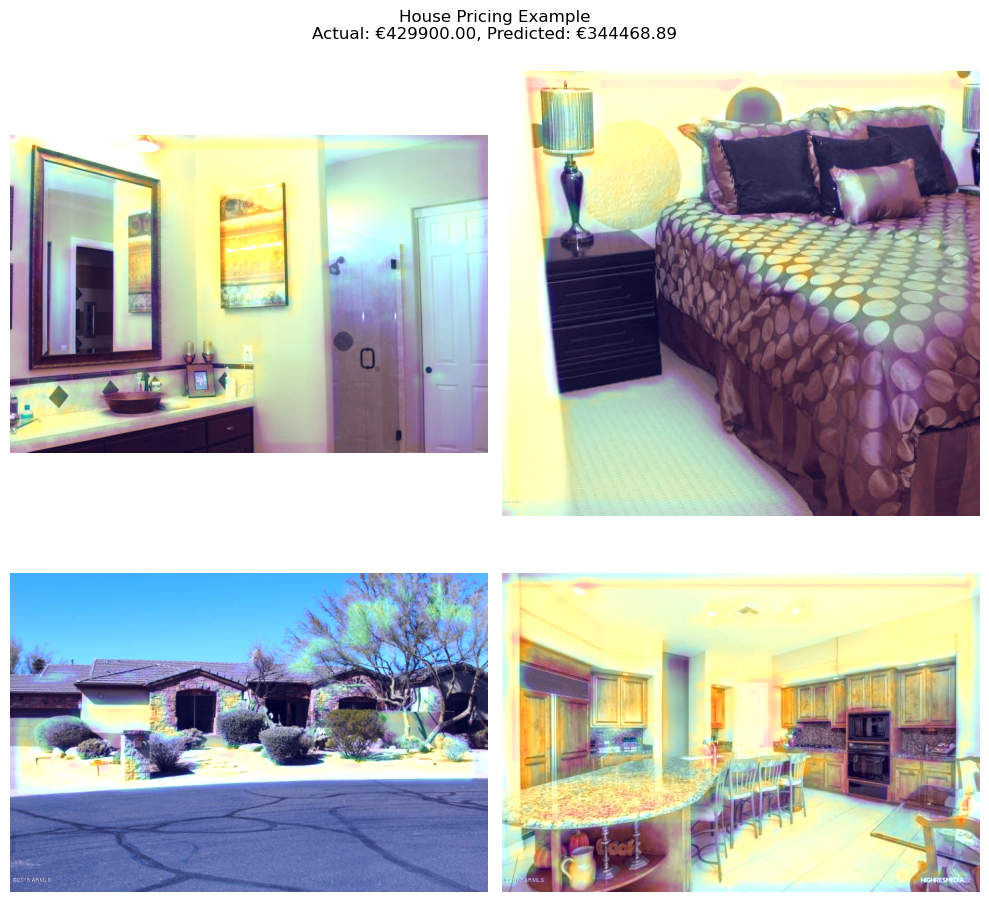

In [48]:
plot_images_and_heatmaps(cnn_model, img_paths, y_test_original[3], average_predictions_hr[3])


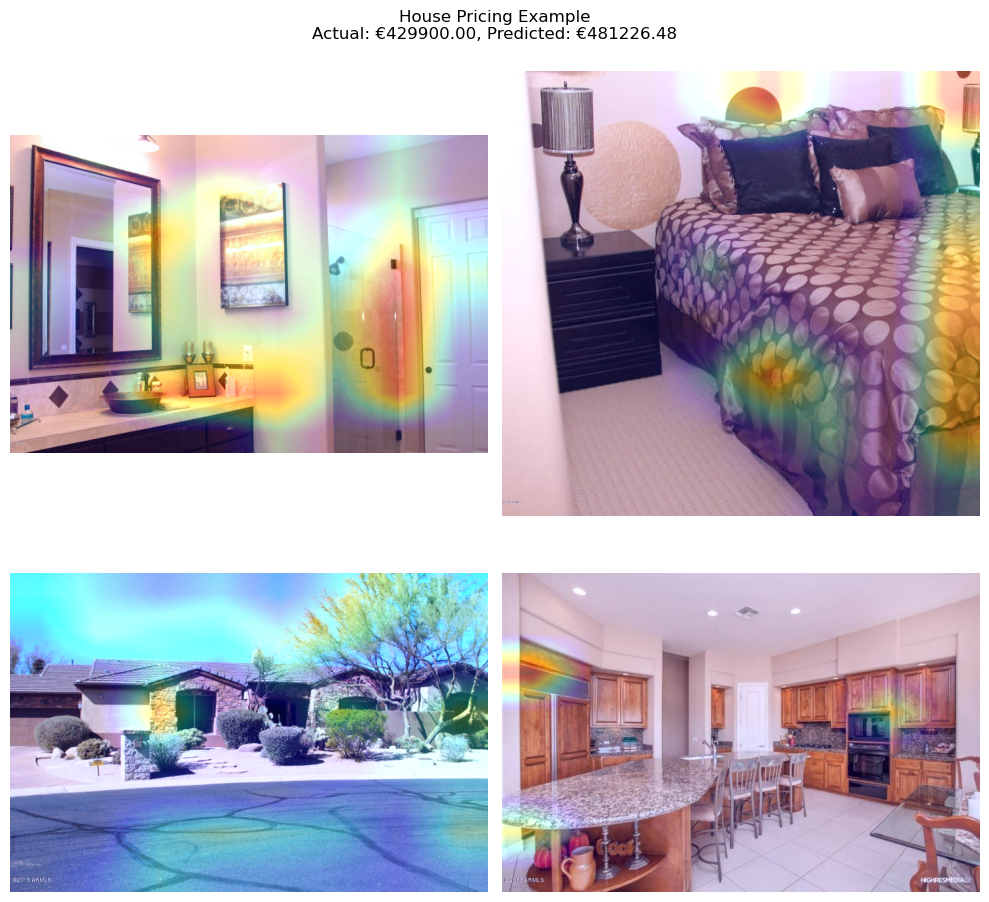

In [49]:
plot_images_and_heatmaps(cnn_model2, img_paths, y_test_original[3], average_predictions_lr[3], (64,64))
